In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# tensorflow.keras.etc is for TF 1.14
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Bidirectional, Activation, Dense, Dropout, Input, Embedding,BatchNormalization
 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json
import numpy as np

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.utils import shuffle
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
## train/test split the text data and labels
'''
with open('/content/gdrive/My Drive/fake_detection/label_data01_processed.json') as f:
  data = json.load(f)

features =np.array([d[0] for d in data]) 
labels =np.array([d[1] for d in data]) 
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 42)
'''

In [ ]:
features_series=[]
labels_series=[]
for i in range(6,10):
  with open('/content/gdrive/My Drive/fake_detection/labeled_data_Feb/label_data02_'+str(i)+'_processed.json') as f:
    data = json.load(f)

    features_series.append(np.array([d[0].replace('via','') for d in data])) 
    labels_series.append(np.array([d[1] for d in data])) 
for i in range(10):
  with open('/content/gdrive/My Drive/fake_detection/labeled_data_Mar/label_data03_'+str(i)+'_processed.json') as f:
    data = json.load(f)

    features_series.append(np.array([d[0] for d in data])) 
    labels_series.append(np.array([d[1] for d in data])) 

In [ ]:
'''
features_series[2]= np.concatenate((features_series[1], features_series[2]), axis=0) 
labels_series[2]= np.concatenate((labels_series[1], labels_series[2]), axis=0) 
'''

In [ ]:
#features_series[2], labels_series[2] = shuffle(features_series[2], labels_series[2], random_state=42)

In [ ]:
## not removing stop words to maintain word context
max_words = 30000
max_len = 200

train_idx=9



token = Tokenizer(num_words=max_words, lower=True, split=' ')
token.fit_on_texts(features_series[train_idx])
sequences = token.texts_to_sequences(features_series[train_idx])
train_sequences_padded = pad_sequences(sequences, maxlen=max_len)


In [ ]:
import pickle

# saving
with open('/content/gdrive/My Drive/fake_detection/tokenizer.pickle', 'wb') as handle:
    pickle.dump(token, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
#with open('tokenizer.pickle', 'rb') as handle:
#    token = pickle.load(handle)

# Test data selection

In [ ]:
 
test_idx=13

# now compare to test values
test_sequences = token.texts_to_sequences(features_series[test_idx])
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
import keras
import tensorflow_addons as tfa
METRICS = [

      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')
]

In [ ]:
embed_dim = 300
lstm_out = 128
batch_size = 32

model = Sequential()
model.add(Embedding(max_words, embed_dim, input_length = max_len))
model.add(Bidirectional(LSTM(lstm_out)))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(1, name='out_layer'))
model.add(Activation('sigmoid'))
radam = tfa.optimizers.RectifiedAdam(lr=2e-3)
model.compile(loss = 'binary_crossentropy', optimizer=tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5) ,metrics = ['accuracy'])# 
print(model.summary())

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 200, 300)          9000000   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 256)               439296    
_________________________________________________________________
dense_62 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_48 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 64)                16448     
_________________________________________________________________
activation_49 (Activation)   (None, 64)              

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
(unique, counts) = np.unique(labels_series[train_idx], return_counts=True)



In [ ]:
print(counts[1]/counts[0])
if counts[1]/counts[0]>10:
  model_checkpoint_callback =  keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_loss',
      mode='max',
      save_best_only=True)
  class_weight = {0: 1, 1: 0.1}
elif counts[1]/counts[0]>=5 and counts[1]/counts[0]<10:
  model_checkpoint_callback =  keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_loss',
      mode='max',
      save_best_only=True)
  class_weight = {0: 1, 1: 0.2}
else:
  model_checkpoint_callback =  keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True)
  class_weight= {0: 1, 1: 1 }
 

7.191780821917808


In [ ]:

history = model.fit(train_sequences_padded, labels_series[train_idx], batch_size=batch_size, epochs = 10, validation_split=0.3, class_weight=class_weight,  callbacks=[model_checkpoint_callback])

Epoch 1/10
40/40 [==============================] - 12s 289ms/step - loss: 0.1999 - accuracy: 0.8821 - val_loss: 0.5974 - val_accuracy: 0.8646
Epoch 2/10
40/40 [==============================] - 9s 237ms/step - loss: 0.1976 - accuracy: 0.8837 - val_loss: 0.5741 - val_accuracy: 0.8646
Epoch 3/10
40/40 [==============================] - 9s 237ms/step - loss: 0.1925 - accuracy: 0.8821 - val_loss: 0.5706 - val_accuracy: 0.8609
Epoch 4/10
40/40 [==============================] - 9s 237ms/step - loss: 0.1698 - accuracy: 0.8829 - val_loss: 0.5049 - val_accuracy: 0.7644
Epoch 5/10
40/40 [==============================] - 9s 237ms/step - loss: 0.1355 - accuracy: 0.8430 - val_loss: 0.5067 - val_accuracy: 0.7199
Epoch 6/10
40/40 [==============================] - 10s 238ms/step - loss: 0.0989 - accuracy: 0.8837 - val_loss: 0.4553 - val_accuracy: 0.8219
Epoch 7/10
40/40 [==============================] - 10s 242ms/step - loss: 0.0591 - accuracy: 0.9418 - val_loss: 0.7587 - val_accuracy: 0.7384
Epo

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model.load_weights(checkpoint_filepath)

# Test RNN

              precision    recall  f1-score   support

           0       0.26      0.21      0.23       384
           1       0.89      0.92      0.90      2765

    accuracy                           0.83      3149
   macro avg       0.57      0.56      0.57      3149
weighted avg       0.81      0.83      0.82      3149



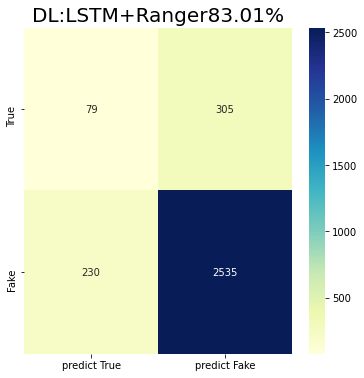

In [ ]:
prediction_bs = model.predict(test_sequences_padded)
predictions=np.where(prediction_bs<0.5,0,1) 
print(classification_report(labels_series[test_idx], predictions))
matrix = confusion_matrix(labels_series[test_idx], predictions)
 
df_cm = pd.DataFrame(matrix, index = ["True","Fake"],
                  columns = ["predict True","predict Fake"])

plt.figure(figsize = (6,6))
plt.title("DL:LSTM+Ranger"+str(round(accuracy_score(labels_series[test_idx], predictions)*100,2))+'%', fontsize =20)
sn.heatmap(df_cm, annot=True, fmt='g', cmap="YlGnBu")

In [ ]:
'''
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Training', 'Validation'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.xticks(list(range(0,16,3)))
'''

In [ ]:
'''
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Training', 'Validation'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks(list(range(0,16,3)))
'''

In [ ]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open('/content/gdrive/My Drive/fake_detection/rnnmodel_03_'+str(train_idx)+'.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('/content/gdrive/My Drive/fake_detection/rnnmodel_03_'+str(train_idx)+'.h5')
print("Saved model to disk")
 


Saved model to disk


In [ ]:
# later...
 
# load json and create model
json_file = open('/content/gdrive/My Drive/fake_detection/rnnmodel_03_'+str(train_idx)+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('/content/gdrive/My Drive/fake_detection/rnnmodel_03_'+str(train_idx)+'.h5')
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(test_sequences_padded, labels_series[test_idx], verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
prediction_bs = loaded_model.predict(test_sequences_padded)
predictions=np.where(prediction_bs<0.5,0,1) 

Loaded model from disk
accuracy: 84.48%


### CNN Model

In [ ]:
from keras import layers
 
model2 = Sequential(
    [
 
        layers.Embedding(max_words,
                         embed_dim, 
                         input_length=max_len),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),
        
        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
radam2 = tfa.optimizers.RectifiedAdam(lr=2e-3)
 
model2.compile(loss='binary_crossentropy',
               optimizer=tfa.optimizers.Lookahead(radam2, sync_period=6, slow_step_size=0.5) ,
              metrics=['accuracy'])
print(model2.summary())

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 200, 300)          9000000   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 196, 128)          192128    
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 128)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_54 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_55 (Dropout)         (None, 64)              

In [ ]:
checkpoint_filepath2 = '/tmp/checkpoint2'
(unique, counts) = np.unique(labels_series[train_idx], return_counts=True)

if counts[1]/counts[0]>10:
  model_checkpoint_callback =  keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_loss',
      mode='max',
      save_best_only=True)
  class_weight = {0: 1, 1: 0.1}
elif counts[1]/counts[0]>=5 and counts[1]/counts[0]<10:
  model_checkpoint_callback =  keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_loss',
      mode='max',
      save_best_only=True)
  class_weight = {0: 1, 1: 0.2}
else:
  model_checkpoint_callback2 =  keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath2,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True)
  class_weight= {0: 1, 1: 1 }
 

In [ ]:
history2 = model2.fit(train_sequences_padded, labels_series[train_idx], batch_size=batch_size, epochs = 10, validation_split=0.3,class_weight=class_weight,    callbacks=[model_checkpoint_callback2])

Epoch 1/10
40/40 [==============================] - 9s 229ms/step - loss: 0.2013 - accuracy: 0.7466 - val_loss: 0.6330 - val_accuracy: 0.8646
Epoch 2/10
40/40 [==============================] - 9s 226ms/step - loss: 0.1976 - accuracy: 0.8837 - val_loss: 0.5872 - val_accuracy: 0.8646
Epoch 3/10
40/40 [==============================] - 9s 226ms/step - loss: 0.1948 - accuracy: 0.8837 - val_loss: 0.5533 - val_accuracy: 0.8646
Epoch 4/10
40/40 [==============================] - 9s 225ms/step - loss: 0.1871 - accuracy: 0.8861 - val_loss: 0.5234 - val_accuracy: 0.8590
Epoch 5/10
40/40 [==============================] - 9s 226ms/step - loss: 0.1726 - accuracy: 0.8996 - val_loss: 0.5519 - val_accuracy: 0.8516
Epoch 6/10
40/40 [==============================] - 9s 226ms/step - loss: 0.1321 - accuracy: 0.9339 - val_loss: 0.4753 - val_accuracy: 0.8330
Epoch 7/10
40/40 [==============================] - 9s 226ms/step - loss: 0.0673 - accuracy: 0.9801 - val_loss: 0.3834 - val_accuracy: 0.8497
Epoch 

In [ ]:
checkpoint_filepath2 = '/tmp/checkpoint2'
model2.load_weights(checkpoint_filepath2)

### test CNN

              precision    recall  f1-score   support

           0       0.14      0.03      0.04       384
           1       0.88      0.98      0.93      2765

    accuracy                           0.86      3149
   macro avg       0.51      0.50      0.48      3149
weighted avg       0.79      0.86      0.82      3149



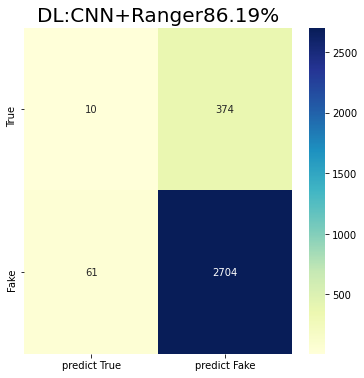

In [ ]:
prediction_bs2 = model2.predict(test_sequences_padded)
predictions2=np.where(prediction_bs2<0.5,0,1) 
print(classification_report(labels_series[test_idx], predictions2))
matrix = confusion_matrix(labels_series[test_idx], predictions2)
 
df_cm = pd.DataFrame(matrix, index = ["True","Fake"],
                  columns = ["predict True","predict Fake"])

plt.figure(figsize = (6,6))
plt.title("DL:CNN+Ranger"+str(round(accuracy_score(labels_series[test_idx], predictions2)*100,2))+'%', fontsize =20)
sn.heatmap(df_cm, annot=True, fmt='g', cmap="YlGnBu")

In [ ]:
from keras.models import model_from_json
# serialize model to JSON
model_json2 = model2.to_json()
with open('/content/gdrive/My Drive/fake_detection/cnnmodel_03_'+str(train_idx)+'.json', "w") as json_file:
    json_file.write(model_json2)
# serialize weights to HDF5
model2.save_weights('/content/gdrive/My Drive/fake_detection/cnnmodel_03_'+str(train_idx)+'.h5')
print("Saved model to disk")

Saved model to disk


In [ ]:
# later...
 
# load json and create model
json_file = open('/content/gdrive/My Drive/fake_detection/cnnmodel_03_'+str(train_idx)+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model2 = model_from_json(loaded_model_json)
# load weights into new model
loaded_model2.load_weights('/content/gdrive/My Drive/fake_detection/cnnmodel_03_'+str(train_idx)+'.h5')
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model2.evaluate(test_sequences_padded, labels_series[test_idx], verbose=0)
print("%s: %.2f%%" % (loaded_model2.metrics_names[1], score[1]*100))
prediction_bs2 = loaded_model2.predict(test_sequences_padded)
predictions2=np.where(prediction_bs2<0.5,0,1) 

Loaded model from disk
accuracy: 87.23%


## ML

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stopw = stopwords.words('english')+['via']
import string
from sklearn.feature_extraction.text import TfidfVectorizer
def tokenize (text):         
    tokens = [word.strip(string.punctuation) for word in RegexpTokenizer(r'\b[a-zA-Z][a-zA-Z0-9]{2,14}\b').tokenize(text)]
    return  [f.lower() for f in tokens if f and f.lower() not in nltk_stopw]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#features, labels
features_SVM_train=[tokenize (text) for text in features_series[train_idx]]

bow_X_train=np.array([np.array(xi) for xi in features_SVM_train])          #   rows: Docs. columns: words

vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=1).fit(bow_X_train)
word_index = vectorizer.vocabulary_
bow_X_train = vectorizer.transform(bow_X_train)



In [ ]:
index_word={word_index[k]:k for k in word_index}# later feature importance

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='not majority', random_state=42)
svmodel = LinearSVC(tol=1.0e-6,max_iter=5000,verbose=1 , random_state=42)
svmodel = Pipeline(steps=[ 
('sampling', smote),
('classifier', svmodel)])

svmodel.fit(bow_X_train, labels_series[train_idx])
 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[LibLinear]

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='not majority',
                       svm_estimator='deprecated')),
                ('classifier',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=5000,
                           multi_class='ovr', penalty='l2', random_state=42,
                           tol=1e-06, verbose=1))],
         verbose=False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier#RandomForestRegressor

rfreg = RandomForestClassifier(n_estimators=300,  max_depth=30, random_state=42)
clf = Pipeline(steps=[ 
('sampling', smote),
('classifier', rfreg)])

clf.fit(bow_X_train, labels_series[train_idx])




/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='not majority',
                       svm_estimator='deprecated')),
                ('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=30, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                

## Test ML

In [ ]:
features_SVM_test=[tokenize (text) for text in features_series[test_idx]]
bow_X_test=np.array([np.array(xi) for xi in features_SVM_test])          #   rows: Docs. columns: words
bow_X_test = vectorizer.transform(bow_X_test)

              precision    recall  f1-score   support

        True     0.2345    0.0885    0.1285       384
        Fake     0.8835    0.9599    0.9201      2765

    accuracy                         0.8536      3149
   macro avg     0.5590    0.5242    0.5243      3149
weighted avg     0.8043    0.8536    0.8236      3149

0.853604318831375


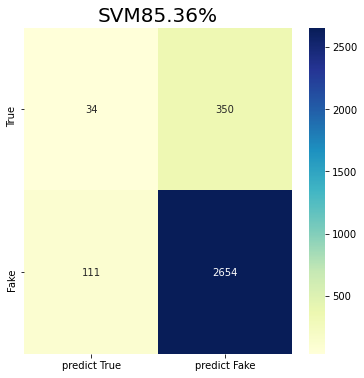

In [ ]:
predicted_labels = svmodel.predict(bow_X_test) 
matrix = confusion_matrix(labels_series[test_idx], predicted_labels)
 
df_cm = pd.DataFrame(matrix, index = ["True","Fake"],
                  columns = ["predict True","predict Fake"])
plt.figure(figsize = (6,6))
plt.title("SVM"+str(round(accuracy_score(labels_series[test_idx], predicted_labels)*100,2))+'%', fontsize =20)
sn.heatmap(df_cm, annot=True, fmt='g', cmap="YlGnBu")

print (classification_report(labels_series[test_idx], predicted_labels, digits=4, target_names=["True","Fake"]))
print(accuracy_score(labels_series[test_idx], predicted_labels))

              precision    recall  f1-score   support

           0     0.2927    0.0312    0.0565       384
           1     0.8803    0.9895    0.9317      2765

    accuracy                         0.8727      3149
   macro avg     0.5865    0.5104    0.4941      3149
weighted avg     0.8087    0.8727    0.8250      3149



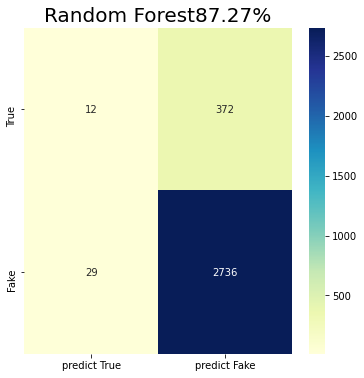

In [ ]:
rfclf_predicted_labels = clf.predict(bow_X_test)
matrix = confusion_matrix(labels_series[test_idx], rfclf_predicted_labels)
 
df_cm = pd.DataFrame(matrix, index = ["True","Fake"],
                  columns = ["predict True","predict Fake"])
plt.figure(figsize = (6,6))
plt.title("Random Forest"+str(round(accuracy_score(labels_series[test_idx], rfclf_predicted_labels)*100,2))+'%', fontsize =20)
sn.heatmap(df_cm, annot=True, fmt='g', cmap="YlGnBu")

print (classification_report(labels_series[test_idx], rfclf_predicted_labels, digits=4))
 

In [ ]:
importances = rfreg.feature_importances_
 
indices = np.argsort(importances)[::-1]  #index_word), reverse=True)
print("Feature ranking:")
std = np.std([tree.feature_importances_ for tree in rfreg.estimators_],
             axis=0)
for f in range(20 ):
    print("%d.  %s : %f " % (f + 1, index_word[indices[f]], round(importances[indices[f]],4)))

Feature ranking:
1.  chinese : 0.052600 
2.  virus : 0.044100 
3.  china : 0.016700 
4.  spread : 0.014000 
5.  trump : 0.013400 
6.  originated : 0.013200 
7.  chinesevirus : 0.012600 
8.  wuhan : 0.009400 
9.  coronavirus : 0.008500 
10.  covid : 0.008200 
11.  american : 0.007100 
12.  world : 0.006500 
13.  liar : 0.005900 
14.  prevent : 0.005700 
15.  pandemic : 0.005400 
16.  racist : 0.005200 
17.  outbreak : 0.005000 
18.  president : 0.004900 
19.  people : 0.004900 
20.  mean : 0.004800 


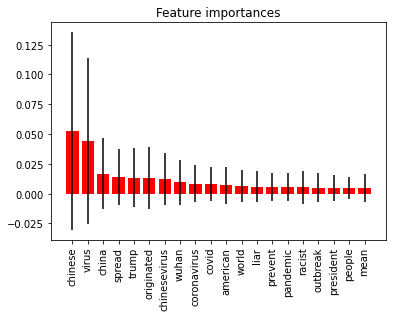

In [ ]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(20), importances[indices][:20],
        color="r", yerr=std[indices][:20], align="center")
ind=[index_word[idx] for idx in indices[:20]]
plt.xticks(range( 20), ind)
plt.xticks(rotation=90)
plt.show()

## Voting


              precision    recall  f1-score   support

           0     0.3519    0.0495    0.0868       384
           1     0.8821    0.9873    0.9317      2765

    accuracy                         0.8730      3149
   macro avg     0.6170    0.5184    0.5092      3149
weighted avg     0.8174    0.8730    0.8287      3149



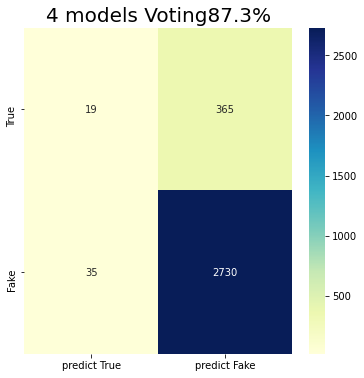

In [ ]:
pred_ensemble_result4=np.array([(rnn+cnn+sv+rf ) for rnn,cnn,sv,rf  in zip(predictions,predictions2,predicted_labels ,rfclf_predicted_labels ) ] )#
pred_ensemble_result =np.where(pred_ensemble_result4<3,0,1) 
matrix = confusion_matrix(labels_series[test_idx], pred_ensemble_result)
 
df_cm = pd.DataFrame(matrix, index = ["True","Fake"],
                  columns = ["predict True","predict Fake"])
plt.figure(figsize = (6,6))
plt.title("4 models Voting"+str(round(accuracy_score(labels_series[test_idx], pred_ensemble_result)*100,2))+'%', fontsize =20)
sn.heatmap(df_cm, annot=True, fmt='g', cmap="YlGnBu")

print (classification_report(labels_series[test_idx], pred_ensemble_result, digits=4))
 

## real teseting

In [ ]:
import warnings
from bs4 import BeautifulSoup
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
import re
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
import os
from collections import defaultdict
 
each_hour_data=defaultdict(dict)
#print(files)
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    
    letters_only = re.sub("[^a-zA-Z.?,]", " ", clean)
    lower_case = letters_only.lower()
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip().replace(" .",'.').replace(" ?",'?').replace(" ,",',') 

In [ ]:
# can it generalize?
fake1 =  """Democratic freshman Rep. Ilhan Omar (D., Minn.) has been holding a series of secret fundraisers with groups that have been tied to the support of terrorism, appearances that have been closed to the press and hidden from public view.
Omar's appearance at these closed-door forums is raising eyebrows in the pro-Israel world due to her repeated and unapologetic public use of anti-Semitic stereotypes accusing Jewish people of controlling foreign policy and politics. With Omar's popularity skyrocketing on the anti-Israel left, it appears her rhetoric is translating into fundraising prowess."""

In [ ]:
fake2 = """
Donald Trump's legacy is anything but a rag to riches story. His dad kicked the bucket with $250-$300 million in the bank. The man who wants to ban all people of a particular religion from travel wasn't born with a silver spoon in his mouth, his was white gold. The only thing more obnoxious than Donald Trump himself, is his family's money-grubbing, bigoted history.
"""

In [ ]:
new_real = """
fact checkers from multiple countries fighting multiple waves of misinformation on coronavirus. 
"""

In [ ]:
new_real2 = """
cnn there s been a run of surgical masks in the us because of the coronavirus scare. 
"""

In [ ]:
new_real3 = """
we had a disease outbreak where i teach a few months ago. if people would have been properly vaccinated, it wouldn t have happened. many students learned they hadn t been vaccinated and went right to the dr to change that. vaccinate. wash your hands. sneeze in your elbow. via
"""

In [ ]:
# tweet requires data precessing
fake_=new_real3
fake=tweet_cleaner(fake_)

# DL prepocessing
real_test_sequences = token.texts_to_sequences([fake])
real_test_sequences_padded = pad_sequences(real_test_sequences, maxlen=max_len)
 

# ML prepocessing
real_test=[tokenize (text) for text in [fake]]
real_X_test=np.array([np.array(xi) for xi in real_test])          #   rows: Docs. columns: words
real_X_test = vectorizer.transform(real_X_test)


# predicting
prediction_bs = model.predict(real_test_sequences_padded)
predictions=np.where(prediction_bs<0.5,0,1) 
 
predicted_labels = svmodel.predict(real_X_test)
rfclf_predicted_labels = clf.predict(real_X_test)

#presentation
result=[predictions[0][0],predicted_labels[0],rfclf_predicted_labels[0] ]
think=['true','fake']
print(fake_)
for who , say in zip(['Mr.DL','Mr.SVM','Mr.RandomForest'  ],result):
  print(who , 'thinks this tweet is', think[say])


we had a disease outbreak where i teach a few months ago. if people would have been properly vaccinated, it wouldn t have happened. many students learned they hadn t been vaccinated and went right to the dr to change that. vaccinate. wash your hands. sneeze in your elbow. via

Mr.DL thinks this tweet is true
Mr.SVM thinks this tweet is true
Mr.RandomForest thinks this tweet is fake
